<a href="https://colab.research.google.com/github/min0j98/mobis_aistudy_2023/blob/master/DL_06_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load LIBRARY

In [1]:
# %tensorflow_version 2.x
## load modules
import cv2 as cv
import matplotlib.pyplot as plt
import os, time
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
print(tf.__version__)

2.14.0


## 2. LOAD DATASET

In [2]:
!git clone https://github.com/min0j98/mobis_aistudy_2023.git

Cloning into 'mobis_aistudy_2023'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 84 (delta 24), reused 27 (delta 0), pack-reused 0
Receiving objects: 100% (84/84), 6.50 MiB | 8.06 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [3]:
!mkdir -p ./data_1000
!unzip '/content/mobis_aistudy_2023/sdl_Data_1000.zip' -d data_1000

Archive:  /content/mobis_aistudy_2023/sdl_Data_1000.zip
 extracting: data_1000/35.4527.jpg   
 extracting: data_1000/35.4561.jpg   
 extracting: data_1000/35.4579.jpg   
 extracting: data_1000/35.4595.jpg   
 extracting: data_1000/35.4617.jpg   
 extracting: data_1000/35.4625.jpg   
 extracting: data_1000/35.4637.jpg   
 extracting: data_1000/35.4644.jpg   
 extracting: data_1000/35.4668.jpg   
 extracting: data_1000/35.4674.jpg   
 extracting: data_1000/35.4681.jpg   
 extracting: data_1000/35.4754.jpg   
 extracting: data_1000/35.4787.jpg   
 extracting: data_1000/35.4796.jpg   
 extracting: data_1000/35.4853.jpg   
 extracting: data_1000/35.4893.jpg   
 extracting: data_1000/35.4994.jpg   
 extracting: data_1000/35.5084.jpg   
 extracting: data_1000/35.5102.jpg   
 extracting: data_1000/35.5113.jpg   
 extracting: data_1000/35.5141.jpg   
 extracting: data_1000/35.5254.jpg   
 extracting: data_1000/35.5281.jpg   
 extracting: data_1000/35.5315.jpg   
 extracting: data_1000/35.5316.j

## 3. 데이터 전처리

In [4]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './data_1000/'

# 이미지 읽기 및 출력
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    plt.imshow(img)
    plt.xticks([]) # x축 눈금
    plt.yticks([]) # y축 눈금
    plt.show()
    return img

#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

#src 경로에 있는 파일 명을 저장합니다.
files = os.listdir(src)

# 경로와 파일명을 입력으로 넣어 확인하고
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.

X,Y = [],[]
for file in files:
  X.append(img_read(src,file)/255.)
  Y.append(float(file[:-4]))


# Train set, Test set으로 나누기
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)


 # (image,image)이미지를 크기의 (image*image,)크기의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(800, 3136)  Datasets_test_shape:(200, 3136)


## VAE 모델 생성

In [5]:
# network parameters
input_shape = np.shape(x_train[0])[0]
original_dim= input_shape
intermediate_dim = 512
latent_dim = 2

## encoder 아키텍처 생성

(None, 2)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_shape (InputLayer)    [(None, 3136)]               0         []                            
                                                                                                  
 encoder_hidden1 (Dense)     (None, 512)                  1606144   ['input_shape[0][0]']         
                                                                                                  
 z_mean (Dense)              (None, 2)                    1026      ['encoder_hidden1[0][0]']     
                                                                                                  
 z_log_var (Dense)           (None, 2)                    1026      ['encoder_hidden1[0][0]']     
                                                                                  

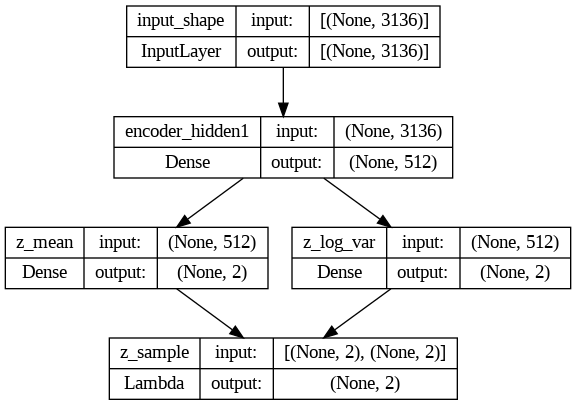

In [62]:
def encoder():
  # 인코더의 입력층을 생성합니다.
  inputs = Input(shape=(input_shape,), name='input_shape')

  # 인코더의 hidden층을 생성합니다. 500개의 유닛을 사용했습니다.
  encoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='encoder_hidden1')(inputs)

  # 평균(mean)과 표준편차(sigma)층을 정의합니다.
  # 이때 sigma 대신 log variance를 사용합니다. 이는 신경망의 출력은 음수를 가질 수 있지만 sigma는 항상 양수여야 하기 때문입니다.
  # 각각 2개의 유닛을 사용했습니다.
  z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden)
  z_log_var = layers.Dense(latent_dim, name='z_log_var')(encoder_hidden)

  # 평균과 표준편차를 래핑하여 Z_sampling층을 만듭니다.

  # Z 샘플링 함수 생성
  def sampling(args):
      z_mean, z_log_var = args
      print(z_mean.shape)
      batch = tf.shape(z_mean)[0]
      dim = tf.shape(z_mean)[1]

      # by default, random_normal has mean = 0 and std = 1.0
      # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출
      epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
      return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

  #  layers.Lambda API 래핑에 사용할 함수와, 유닛수(n,)를 지정합니다.
  z_sampling = layers.Lambda(sampling, (latent_dim,), name='z_sample')([z_mean, z_log_var])

  # 하나의 입력과 다중충력을 포함하는 encoder 모델을 만듭니다.
  return Model(inputs,[z_mean,z_log_var,z_sampling], name='encoder')

encoder = encoder()

# 인코더 네트워크를 확인합니다.
encoder.summary()

from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

## decoder 아키텍처 생성

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_z (InputLayer)        [(None, 2)]               0         
                                                                 
 decoder_hidden (Dense)      (None, 512)               1536      
                                                                 
 output (Dense)              (None, 3136)              1608768   
                                                                 
Total params: 1610304 (6.14 MB)
Trainable params: 1610304 (6.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


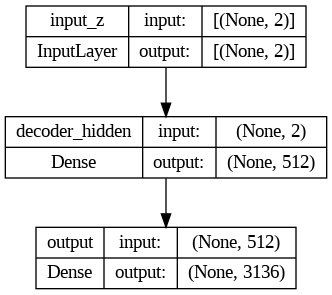

In [63]:
def decoder():

  # 디코더의 입력층을 생성합니다. (Decoder의 입력은 latent입니다)
  input_z = Input(shape=(latent_dim,), name='input_z')

  # 디코더의 hidden층을 생성합니다. 인코더와 동일하게 500개의 유닛을 사용했습니다.
  decoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='decoder_hidden')(input_z)

  # 디코더의 출력층은 인코더 입력벡터 수만큼 유닛을 사용합니다.
  outputs = layers.Dense(original_dim, activation='sigmoid',name='output')(decoder_hidden)

  return Model(input_z, outputs, name='decoder')

decoder = decoder()

# 디코더의 네트워크 확인.
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

## combined 모델 (VAE아키텍처) 생성

(None, 2)
Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 3136)]            0         
                                                                 
 encoder (Functional)        [(None, 2),               1608196   
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 3136)              1610304   
                                                                 
Total params: 3218500 (12.28 MB)
Trainable params: 3218500 (12.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


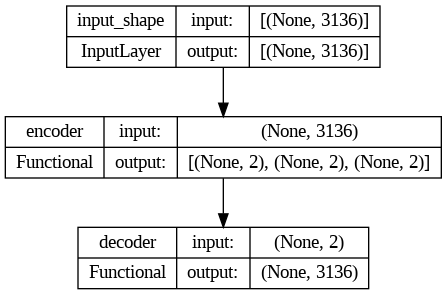

In [64]:
def vae():
  # vae는 입력으로 이미지로 들어와 encoder를 통해 z_sampling 되어 decoder로 출력됩니다.
  inputs = Input(shape=(input_shape,), name='input_shape')
  outputs = decoder(encoder(inputs)[2]) #[0]:z_mean, [1]:z_log_var,[2]:z_sampling

  return Model(inputs,outputs, name='vae_mlp')

#VAE 모델 정의
model = vae()

#모델 네트워크 확인
model.summary()
plot_model(model,to_file='vae_mlp.png',show_shapes=True)

## VAE 모델 학습

In [65]:
# Hyperparameters
num_epochs = 100
batch_size = 20
learning_rate = 1e-3

In [68]:
# 모델 학습 loss, optimizer 정의
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
def vae_loss(x,recon_x):
    # (1)Reconstruct loss (Marginal_likelihood) : Cross-entropy
    z_mean,z_log_var,z_sampling = encoder(x)
    recon_x=decoder(z_sampling)
    reconstruction_loss = tf.keras.losses.binary_crossentropy(x,recon_x)
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    # (2) KL divergence(Latent_loss)
    kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean)+ tf.exp(z_log_var)- z_log_var -1, 1)
    return tf.reduce_mean(reconstruction_loss + kl_loss) #ELBO(=VAE_loss)

model.compile(optimizer=adam,loss=vae_loss)

In [69]:
# 모델 학습
hist = model.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size )
#학습된 VAE 모델 저장
model.save_weights('vae_bracket.h5')

Epoch 1/100
(20, 2)
(20, 2)
(20, 2)
(20, 2)
40/40 [==============================] - 3s 36ms/step - loss: 1950.3414
Epoch 2/100
40/40 [==============================] - 2s 52ms/step - loss: 1810.0598
Epoch 3/100
40/40 [==============================] - 2s 52ms/step - loss: 1784.3644
Epoch 4/100
40/40 [==============================] - 1s 36ms/step - loss: 1771.2273
Epoch 5/100
40/40 [==============================] - 1s 35ms/step - loss: 1761.5305
Epoch 6/100
40/40 [==============================] - 1s 34ms/step - loss: 1753.4144
Epoch 7/100
40/40 [==============================] - 1s 35ms/step - loss: 1748.9413
Epoch 8/100
40/40 [==============================] - 1s 35ms/step - loss: 1745.8483
Epoch 9/100
40/40 [==============================] - 1s 35ms/step - loss: 1741.7322
Epoch 10/100
40/40 [==============================] - 1s 35ms/step - loss: 1736.9937
Epoch 11/100
40/40 [==============================] - 2s 48ms/step - loss: 1731.1669
Epoch 12/100
40/40 [======================

(None, 2)
7/7 [==============================] - 0s 8ms/step


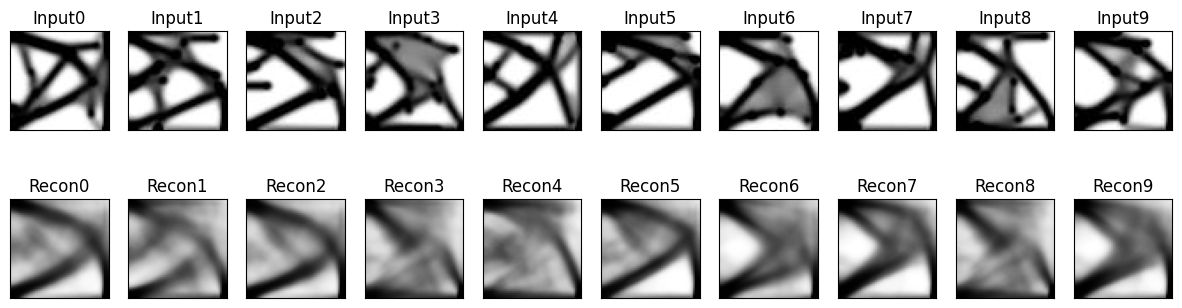

In [70]:
recon_x_test = model.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()


1/1 [==============================] - 0s 31ms/step


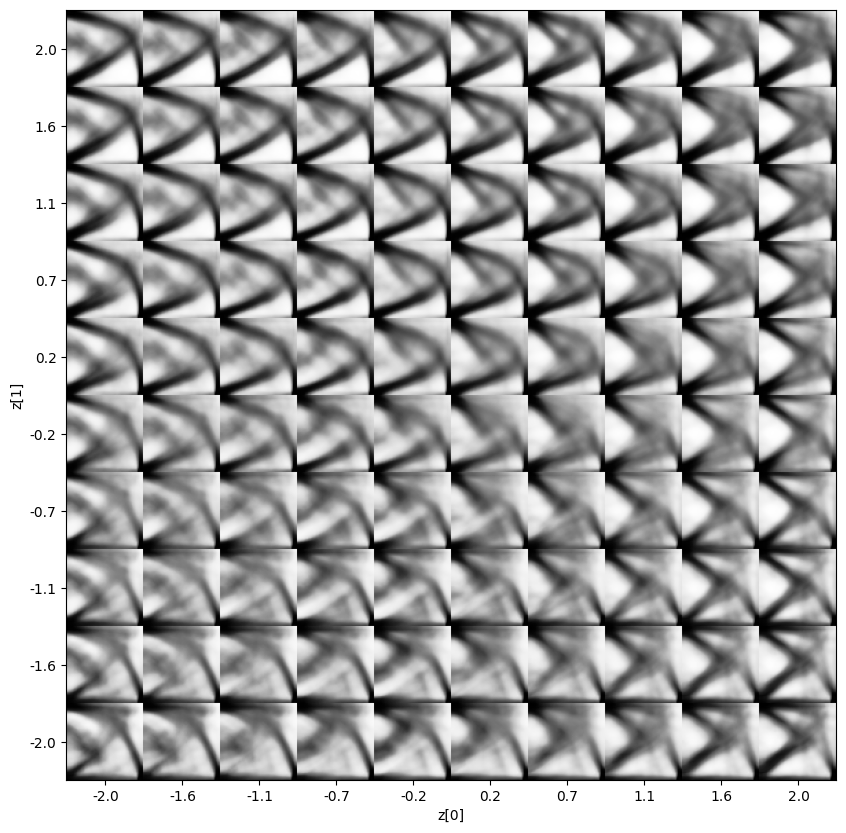

In [71]:
# 학습모델이 생성한 Manifold를 plot하는 함수 정의
def plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_test = data
    filename = "digits_over_latent.png"
    # display a 30x30 2D manifold of digitsa
    n = 10
    digit_size = 56
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

(20, 2)
10/10 [==============================] - 0s 5ms/step


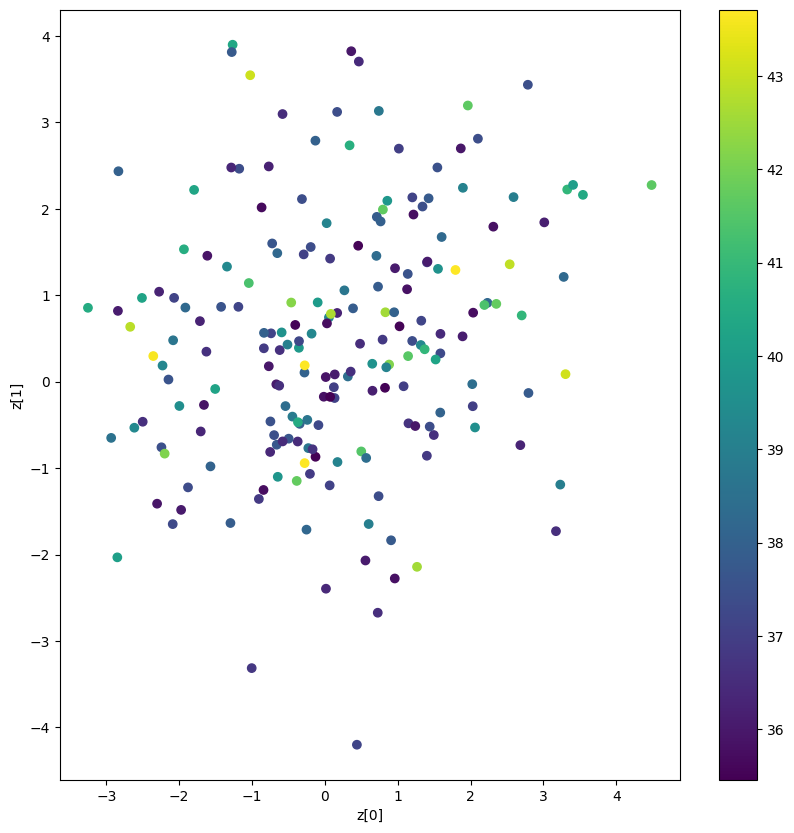

In [72]:
def tsne_plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    #filename = os.path.join(model_name, "vae_mean.png")
    filename = "vae_mean.png"
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(10, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

tsne_plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")

In [73]:
def linear_interpolation(x_from, x_to, steps=10):
    n = steps + 1

    t_from = x_from
    t_to = x_to

    diff = t_to - t_from
    inter = np.zeros((n, t_from.shape[0]))
    for i in range(n):
        inter[i] = t_from + i / steps * diff

    return decoder.predict(inter)

In [74]:
target_a = np.array([1, 1]) # 타겟 시작 좌표
target_b = np.array([10, 10]) # 타겟 끝 좌표
z_decoder_imgs = linear_interpolation(target_a,target_b, 10)

1/1 [==============================] - 0s 22ms/step


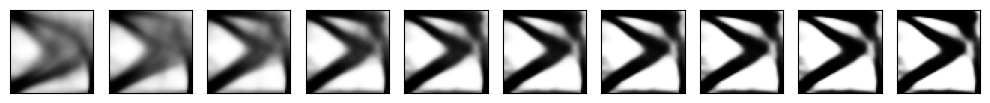

In [75]:
N = 1
M = 10
img_size= 56
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i * M + j
        ax = fig.add_subplot(N, M, k+1)
        ax.imshow(np.reshape(z_decoder_imgs[k], (img_size, img_size)), cmap=plt.cm.gist_gray)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()